## Домашнее задание №8

В данном задании вам предстоит детально рассмотреть механизм Attention (и реализовать несколько его вариантов), а также вернуться к задаче классификации текстов из задания №6 и решить ее с использованием BERT.

In [4]:
import os
import random

import numpy as np
import pandas as pd

from sklearn.metrics import roc_auc_score, roc_curve, accuracy_score

import torch
import torch.nn as nn
import torch.nn.functional as F

import matplotlib.pyplot as plt
from IPython.display import clear_output 
%matplotlib inline

### Задание №1. Реализация Attention

В данной задаче вам предстоит реализовать механизм Attention, в частности несколько способов подсчета attention scores. Конечно, в популярных фреймворках данный механизм уже реализован, но для лучшего понимания вам предстоит реализовать его с помощью `numpy`.

Ваше задание в данной задаче: реализовать `additive` (аддитивный) и `multiplicative` (мультипликативный) варианты Attention. Для вашего удобства (и для примера) `dot product` attention (основанный на скалярном произведении) уже реализован.

Детальное описание данных типов Attention доступно в лекционных слайдах.

Text(0.5, 1.0, 'Decoder state')

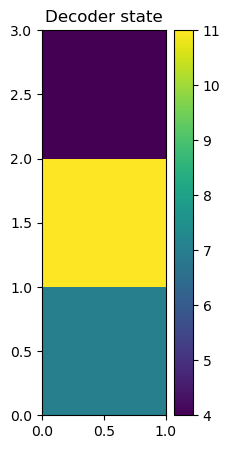

In [5]:
decoder_hidden_state = np.array([7, 11, 4]).astype(float)[:, None]

plt.figure(figsize=(2, 5))
plt.pcolormesh(decoder_hidden_state)
plt.colorbar()
plt.title('Decoder state')

#### Dot product attention (пример реализации)
Рассмотрим единственное состояние энкодера – вектор с размерностью `(n_hidden, 1)`, где `n_hidden = 3`:

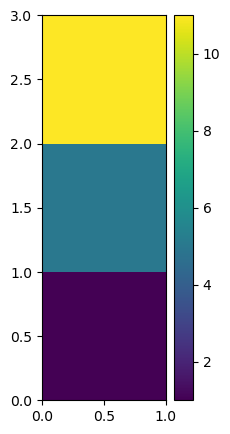

In [6]:
single_encoder_hidden_state = np.array([1, 5, 11]).astype(float)[:, None]

plt.figure(figsize=(2, 5))
plt.pcolormesh(single_encoder_hidden_state)
plt.colorbar()

Attention score между данными состояниями энкодера и декодера вычисляются просто как скалярное произведение:

In [7]:
np.dot(decoder_hidden_state.T, single_encoder_hidden_state)

array([[106.]])

В общем случае состояний энкодера, конечно, несколько. Attention scores вычисляются с каждым из состояний энкодера:

In [8]:
encoder_hidden_states = np.array([
    [1, 5, 11],
    [7, 4, 1],
    [8, 12, 2],
    [-9, 0, 1]
]).astype(float).T

encoder_hidden_states

array([[ 1.,  7.,  8., -9.],
       [ 5.,  4., 12.,  0.],
       [11.,  1.,  2.,  1.]])

Тогда для подсчета скалярных произведений между единственным состоянием декодера и всеми состояниями энкодера можно воспользоваться следующей функцией (которая по факту представляет собой просто матричное умножение и приведение типов):

In [9]:
def dot_product_attention_score(decoder_hidden_state, encoder_hidden_states):
    '''
    decoder_hidden_state: np.array of shape (n_features, 1)
    encoder_hidden_states: np.array of shape (n_features, n_states)
    
    return: np.array of shape (1, n_states)
        Array with dot product attention scores
    '''
    attention_scores = np.dot(decoder_hidden_state.T, encoder_hidden_states)
    return attention_scores

In [10]:
dot_product_attention_score(decoder_hidden_state, encoder_hidden_states)

array([[106.,  97., 196., -59.]])

Для подсчета "весов" нам необходим Softmax:

In [11]:
def softmax(vector):
    '''
    vector: np.array of shape (n, m)
    
    return: np.array of shape (n, m)
        Matrix where softmax is computed for every row independently
    '''
    nice_vector = vector - vector.max()
    exp_vector = np.exp(nice_vector)
    exp_denominator = np.sum(exp_vector, axis=1)[:, np.newaxis]
    softmax_ = exp_vector / exp_denominator
    return softmax_

In [12]:
weights_vector = softmax(dot_product_attention_score(decoder_hidden_state, encoder_hidden_states))

weights_vector

array([[8.19401262e-040, 1.01122149e-043, 1.00000000e+000,
        1.79848622e-111]])

Наконец, воспользуемся данными весами и вычислим итоговый вектор, как и описано для dot product attention.

[[ 8.]
 [12.]
 [ 2.]]


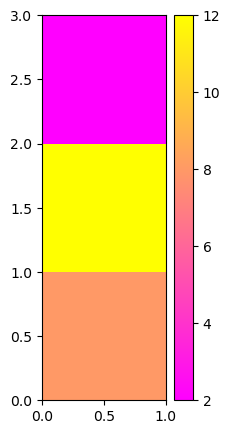

In [13]:
attention_vector = weights_vector.dot(encoder_hidden_states.T).T
print(attention_vector)

plt.figure(figsize=(2, 5))
plt.pcolormesh(attention_vector, cmap='spring')
plt.colorbar()

Данный вектор аккумулирует в себе информацию из всех состояний энкодера, взвешенную на основе близости к заданному состоянию декодера.

Реализуем все вышеописанные преобразования в единой функции:

In [14]:
def dot_product_attention(decoder_hidden_state, encoder_hidden_states):
    '''
    decoder_hidden_state: np.array of shape (n_features, 1)
    encoder_hidden_states: np.array of shape (n_features, n_states)
    
    return: np.array of shape (n_features, 1)
        Final attention vector
    '''
    softmax_vector = softmax(dot_product_attention_score(decoder_hidden_state, encoder_hidden_states))
    attention_vector = softmax_vector.dot(encoder_hidden_states.T).T
    return attention_vector

In [15]:
assert (attention_vector == dot_product_attention(decoder_hidden_state, encoder_hidden_states)).all()

#### Multiplicative attention
Ваша текущая задача: реализовать multiplicative attention.
$$ e_i = \mathbf{s}^TW_{mult}\mathbf{h}_i $$

Матрица весов `W_mult` задана ниже. 
Стоит заметить, что multiplicative attention позволяет работать с состояниями энкодера и декодера различных размерностей, поэтому состояния энкодера будут обновлены:

In [16]:
encoder_hidden_states_complex = np.array([
    [1, 5, 11, 4, -4],
    [7, 4, 1, 2, 2],
    [8, 12, 2, 11, 5],
    [-9, 0, 1, 8, 12]
]).astype(float).T

W_mult = np.array([
    [-0.78, -0.97, -1.09, -1.79,  0.24],
    [ 0.04, -0.27, -0.98, -0.49,  0.52],
    [ 1.08,  0.91, -0.99,  2.04, -0.15]
])

In [17]:
def multiplicative_attention(decoder_hidden_state, encoder_hidden_states, W_mult):
    '''
    decoder_hidden_state: np.array of shape (n_features_dec, 1)
    encoder_hidden_states: np.array of shape (n_features_enc, n_states)
    W_mult: np.array of shape (n_features_dec, n_features_enc)
    
    return: np.array of shape (n_features_enc, 1)
        Final attention vector
    '''
    # s^T * W_mult: (1, n_features_dec) * (n_features_dec, n_features_enc) -> (1, n_features_enc)
    weighted_decoder = np.dot(decoder_hidden_state.T, W_mult)
    # (1, n_features_enc) * (n_features_enc, n_states) -> (1, n_states)
    attention_scores = np.dot(weighted_decoder, encoder_hidden_states)
    # Softmax для весов
    softmax_weights = softmax(attention_scores)
    # (1, n_states) * (n_states, n_features_enc) -> (1, n_features_enc), транспонируем
    attention_vector = np.dot(softmax_weights, encoder_hidden_states.T).T
    return attention_vector

# Тест
multi_vector = multiplicative_attention(decoder_hidden_state, encoder_hidden_states_complex, W_mult)
print("Multiplicative attention vector:\n", multi_vector)

Multiplicative attention vector:
 [[-9.00000000e+00]
 [ 1.01553049e-19]
 [ 1.00000000e+00]
 [ 8.00000000e+00]
 [ 1.20000000e+01]]


#### Additive attention
Теперь вам предстоит реализовать additive attention.

$$ e_i = \mathbf{v}^T \text{tanh} (W_{add-enc} \mathbf{h}_i + W_{add-dec} \mathbf{s}) $$

Матрицы весов `W_add_enc` и `W_add_dec` доступны ниже, как и вектор весов `v_add`. Для вычисления активации можно воспользоваться `np.tanh`.

In [18]:
v_add = np.array([[-0.35, -0.58,  0.07,  1.39, -0.79, -1.78, -0.35]]).T

W_add_enc = np.array([
    [-1.34, -0.1 , -0.38,  0.12, -0.34],
    [-1.  ,  1.28,  0.49, -0.41, -0.32],
    [-0.39, -1.38,  1.26,  1.21,  0.15],
    [-0.18,  0.04,  1.36, -1.18, -0.53],
    [-0.23,  0.96,  1.02,  0.39, -1.26],
    [-1.27,  0.89, -0.85, -0.01, -1.19],
    [ 0.46, -0.12, -0.86, -0.93, -0.4 ]
])

W_add_dec = np.array([
    [-1.62, -0.02, -0.39],
    [ 0.43,  0.61, -0.23],
    [-1.5 , -0.43, -0.91],
    [-0.14,  0.03,  0.05],
    [ 0.85,  0.51,  0.63],
    [ 0.39, -0.42,  1.34],
    [-0.47, -0.31, -1.34]
])

In [19]:
def additive_attention(decoder_hidden_state, encoder_hidden_states, v_add, W_add_enc, W_add_dec):
    '''
    decoder_hidden_state: np.array of shape (n_features_dec, 1)
    encoder_hidden_states: np.array of shape (n_features_enc, n_states)
    v_add: np.array of shape (n_features_int, 1)
    W_add_enc: np.array of shape (n_features_int, n_features_enc)
    W_add_dec: np.array of shape (n_features_int, n_features_dec)
    
    return: np.array of shape (n_features_enc, 1)
        Final attention vector
    '''
    # W_add_enc * h_i: (n_features_int, n_features_enc) * (n_features_enc, n_states) -> (n_features_int, n_states)
    enc_transformed = np.dot(W_add_enc, encoder_hidden_states)
    # W_add_dec * s: (n_features_int, n_features_dec) * (n_features_dec, 1) -> (n_features_int, 1)
    dec_transformed = np.dot(W_add_dec, decoder_hidden_state)
    # Сумма с broadcasting
    combined = enc_transformed + dec_transformed
    # Tanh
    tanh_combined = np.tanh(combined)
    # v^T * tanh: (1, n_features_int) * (n_features_int, n_states) -> (1, n_states)
    attention_scores = np.dot(v_add.T, tanh_combined)
    # Softmax
    softmax_weights = softmax(attention_scores)
    # (1, n_states) * (n_states, n_features_enc) -> (1, n_features_enc), транспонируем
    attention_vector = np.dot(softmax_weights, encoder_hidden_states.T).T
    return attention_vector

# Тест
add_vector = additive_attention(decoder_hidden_state, encoder_hidden_states_complex, v_add, W_add_enc, W_add_dec)
print("Additive attention vector:\n", add_vector)

Additive attention vector:
 [[4.64510711]
 [6.6372749 ]
 [3.11601386]
 [6.2104178 ]
 [3.06285127]]


Сдайте функции `multiplicative_attention` и `additive_attention` в контест.

Не забудьте про импорт `numpy`!

In [20]:
# Сохранение функций для контеста
with open('attention.py', 'w') as f:
    f.write('''
import numpy as np

def softmax(vector):
    nice_vector = vector - vector.max()
    exp_vector = np.exp(nice_vector)
    exp_denominator = np.sum(exp_vector, axis=1)[:, np.newaxis]
    softmax_ = exp_vector / exp_denominator
    return softmax_

def multiplicative_attention(decoder_hidden_state, encoder_hidden_states, W_mult):
    weighted_decoder = np.dot(decoder_hidden_state.T, W_mult)
    attention_scores = np.dot(weighted_decoder, encoder_hidden_states)
    softmax_weights = softmax(attention_scores)
    attention_vector = np.dot(softmax_weights, encoder_hidden_states.T).T
    return attention_vector

def additive_attention(decoder_hidden_state, encoder_hidden_states, v_add, W_add_enc, W_add_dec):
    enc_transformed = np.dot(W_add_enc, encoder_hidden_states)
    dec_transformed = np.dot(W_add_dec, decoder_hidden_state)
    combined = enc_transformed + dec_transformed
    tanh_combined = np.tanh(combined)
    attention_scores = np.dot(v_add.T, tanh_combined)
    softmax_weights = softmax(attention_scores)
    attention_vector = np.dot(softmax_weights, encoder_hidden_states.T).T
    return attention_vector
''')
print("File 'attention.py' saved for contest submission.")

File 'attention.py' saved for contest submission.


### Задание №2 (опциональное). Классификация текстов с использованием предобученной языковой модели.

Вновь вернемся к набору данных SST-2. Разобьем выборку на train и test аналогично заданию №6.

In [21]:
# Загрузка holdout-выборки
import requests
import os

url = 'https://github.com/MSUcourses/Data-Analysis-with-Python/raw/main/Deep%20Learning/holdout_texts08.npy'
response = requests.get(url)
if response.status_code == 200:
    with open('holdout_texts08.npy', 'wb') as f:
        f.write(response.content)
    print("File 'holdout_texts08.npy' downloaded successfully.")
else:
    raise Exception(f"Failed to download holdout_texts08.npy. Status code: {response.status_code}")

File 'holdout_texts08.npy' downloaded successfully.


In [22]:
# Загрузка данных
df = pd.read_csv(
    'https://raw.githubusercontent.com/MSUcourses/Data-Analysis-with-Python/main/Deep%20Learning/Files/STT2_train_task08.tsv',
    delimiter='\t',
    header=None
)
texts_train = df[0].values[:5000]
y_train = df[1].values[:5000]
texts_test = df[0].values[5000:]
y_test = df[1].values[5000:]
texts_holdout = np.load('holdout_texts08.npy', allow_pickle=True)
texts_holdout[:5]

array(['gee , a second assassin shot kennedy ?',
       "from the big giant titles of the opening credits to elmer bernstein 's perfectly melodic score , haynes gets just about everything right",
       'the movie is well shot and very tragic , and one to ponder after the credits roll',
       'the movie quickly drags on becoming boring and predictable',
       "a mixed bag of a comedy that ca n't really be described as out of this world"],
      dtype=object)

Весь остальной код предстоит написать вам.

Для успешной сдачи на максимальный балл необходимо добиться хотя бы __84.5% accuracy на тестовой части выборки__.

In [ ]:
# Установка библиотеки transformers
!pip install -q transformers

from transformers import BertTokenizer, BertForSequenceClassification, AdamW, get_linear_schedule_with_warmup
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler

# Токенизация текстов
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

def tokenize_texts(texts, max_len=128):
    input_ids, attention_masks = [], []

    for text in texts:
        encoded_dict = tokenizer.encode_plus(
            str(text),
            add_special_tokens=True,
            max_length=max_len,
            padding='max_length',
            return_attention_mask=True,
            return_tensors='pt',
            truncation=True
        )

        input_ids.append(encoded_dict['input_ids'])
        attention_masks.append(encoded_dict['attention_mask'])

    input_ids = torch.cat(input_ids, dim=0)
    attention_masks = torch.cat(attention_masks, dim=0)

    return input_ids, attention_masks

input_ids_train, attention_masks_train = tokenize_texts(texts_train)
input_ids_test, attention_masks_test = tokenize_texts(texts_test)
input_ids_holdout, attention_masks_holdout = tokenize_texts(texts_holdout)

# Создание датасетов и загрузчиков данных
batch_size = 8

train_data = TensorDataset(input_ids_train, attention_masks_train, torch.tensor(y_train, dtype=torch.long))
train_sampler = RandomSampler(train_data)
train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=batch_size)

test_data = TensorDataset(input_ids_test, attention_masks_test, torch.tensor(y_test, dtype=torch.long))
test_sampler = SequentialSampler(test_data)
test_dataloader = DataLoader(test_data, sampler=test_sampler, batch_size=batch_size)

holdout_data = TensorDataset(input_ids_holdout, attention_masks_holdout)
holdout_sampler = SequentialSampler(holdout_data)
holdout_dataloader = DataLoader(holdout_data, sampler=holdout_sampler, batch_size=batch_size)

# Инициализация модели
model = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=2)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

# Оптимизатор и планировщик
optimizer = AdamW(model.parameters(), lr=2e-5, eps=1e-8)
epochs = 3
total_steps = len(train_dataloader) * epochs
scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps=0, num_training_steps=total_steps)

# Функция обучения
def train_epoch():
    model.train()
    total_train_loss = 0
    total_train_correct = 0
    total_train_samples = 0

    for batch in train_dataloader:
        input_ids = batch[0].to(device)
        attention_masks = batch[1].to(device)
        labels = batch[2].to(device)

        model.zero_grad()
        outputs = model(input_ids, attention_mask=attention_masks, labels=labels)
        loss = outputs.loss
        logits = outputs.logits

        total_train_loss += loss.item()
        preds = torch.argmax(logits, dim=1)
        total_train_correct += (preds == labels).sum().item()
        total_train_samples += labels.size(0)

        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        optimizer.step()
        scheduler.step()

    avg_train_loss = total_train_loss / len(train_dataloader)
    avg_train_accuracy = total_train_correct / total_train_samples

    return avg_train_loss, avg_train_accuracy

# Обучение модели
for epoch in range(epochs):
    train_loss, train_accuracy = train_epoch()
    clear_output(wait=True)
    print(f"Epoch {epoch + 1}/{epochs}, Loss: {train_loss:.4f}, Train Accuracy: {train_accuracy:.4f}")

# Оценка модели
def evaluate(model, dataloader, has_labels=True):
    model.eval()
    probas = []
    total_correct = 0
    total_samples = 0

    for batch in dataloader:
        input_ids = batch[0].to(device)
        attention_masks = batch[1].to(device)

        with torch.no_grad():
            outputs = model(input_ids, attention_mask=attention_masks)
            logits = outputs.logits
            probs = F.softmax(logits, dim=1).cpu().numpy()
            probas.append(probs)

            if has_labels:
                labels = batch[2].to(device)
                preds = torch.argmax(logits, dim=1)
                total_correct += (preds == labels).sum().item()
                total_samples += labels.size(0)

    probas = np.concatenate(probas, axis=0)
    accuracy = total_correct / total_samples if has_labels else None
    return probas, accuracy

# Получение предсказаний
train_probas, train_accuracy = evaluate(model, train_dataloader)
test_probas, test_accuracy = evaluate(model, test_dataloader)
holdout_probas, _ = evaluate(model, holdout_dataloader, has_labels=False)

print(f"Train accuracy: {train_accuracy:.4f}")
print(f"Test accuracy: {test_accuracy:.4f}")

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

C:\Users\arkhi\anaconda3\Lib\site-packages\huggingface_hub\file_download.py:144: UserWarning: `huggingface_hub` cache-system uses symlinks by default to efficiently store duplicated files but your machine does not support them in C:\Users\arkhi\.cache\huggingface\hub\models--bert-base-uncased. Caching files will still work but in a degraded version that might require more space on your disk. This warning can be disabled by setting the `HF_HUB_DISABLE_SYMLINKS_WARNING` environment variable. For more details, see https://huggingface.co/docs/huggingface_hub/how-to-cache#limitations.
To support symlinks on Windows, you either need to activate Developer Mode or to run Python as an administrator. In order to activate developer mode, see this article: https://docs.microsoft.com/en-us/windows/apps/get-started/enable-your-device-for-development
  warnings.warn(message)


vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
C:\Users\arkhi\anaconda3\Lib\site-packages\transformers\optimization.py:591: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


#### Сдача задания в контест
Сохраните в словарь `out_dict` вероятности принадлежности к нулевому и первому классу соответственно:

In [ ]:
out_dict = {
    'train': train_probas,
    'test': test_probas,
    'holdout': holdout_probas,
}

Несколько `assert`'ов для проверки вашей посылки:

In [ ]:
assert isinstance(out_dict['train'], np.ndarray), 'Dict values should be numpy arrays'
assert out_dict['train'].shape == (5000, 2), 'The predicted probas shape does not match the train set size'
assert np.allclose(out_dict['train'].sum(axis=1), 1.), 'Probas do not sum up to 1 for some of the objects'

assert isinstance(out_dict['test'], np.ndarray), 'Dict values should be numpy arrays'
assert out_dict['test'].shape == (1920, 2), 'The predicted probas shape does not match the test set size'
assert np.allclose(out_dict['test'].sum(axis=1), 1.), 'Probas do not sum up to 1 for some of the object'

assert isinstance(out_dict['holdout'], np.ndarray), 'Dict values should be numpy arrays'
assert out_dict['holdout'].shape == (500, 2), 'The predicted probas shape does not match the holdout set size'
assert np.allclose(out_dict['holdout'].sum(axis=1), 1.), 'Probas do not sum up to 1 for some of the object'

Запустите код ниже для генерации посылки и сдайте файл `submission_dict_hw08.npy`.

In [ ]:
# do not change the code in the block below
# __________start of block__________

np.save('submission_dict_hw08.npy', out_dict, allow_pickle=True)
print('File saved to `submission_dict_hw08.npy`')
# __________end of block__________

На этом задание завершено. Поздравляем!